# Preliminary Experiment for _AKU_

Bernhard Bermeitinger, bernhard.bermeitinger@uni-passau.de

In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import os
import math
from glob import glob
import random
import re
from collections import Counter
import shutil

import subprocess

In [3]:
import cv2
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [4]:
LABEL = 'moe'

from_env = os.getenv('LABEL')
if from_env is not None:
    LABEL = from_env

if LABEL not in ['gar', 'moe']:
    print("wrong label: ", LABEL)

In [5]:
NUM_GPUS = int(str(subprocess.check_output(["nvidia-smi", "-L"])).count('UUID'))

if NUM_GPUS < 1:
    print("NO GPU FOUND, WILL USE CPU")
    NUM_GPUS = 1

else:
    print("Using {} GPUs".format(NUM_GPUS))

Using 1 GPUs


In [6]:
INDIR = os.path.join("/data", "AKU")
OUTDIR = os.path.join("/output")

# Data Reading

In [7]:
df = pd.read_csv(os.path.join(INDIR, 'komplett', 'data.csv'))
df.head(5)

image gar_label moe_label
0  /data/AKU/komplett/converted/GArG19_Moe196_D_A...   gar_g19   moe_196
1  /data/AKU/komplett/converted/Gar0_192B_HT_pEbe...     gar_0       NaN
2  /data/AKU/komplett/converted/Gar0_Moe125B_HT_p...     gar_0  moe_125b
3  /data/AKU/komplett/converted/Gar0_Moe125B_HT_p...     gar_0  moe_125b
4  /data/AKU/komplett/converted/Gar0_Moe125B_HT_p...     gar_0  moe_125b

In [8]:
other_columns = list(df.columns)
other_columns.remove('image')
other_columns.remove("{}_label".format(LABEL))

In [9]:
df = df.dropna(subset=["{}_label".format(LABEL)])
df = df.drop(columns=other_columns)
df = df.rename(columns={"{}_label".format(LABEL): 'label'})

In [10]:
label_counter = Counter(df.label)

MIN_APPEARANCE = 25

allowed_labels = [label for label, count in label_counter.most_common() if count >= MIN_APPEARANCE]

df = df[df.label.isin(allowed_labels)]

NUM_CLASSES = len(df.label.unique())
print("NUM_CLASSES:", NUM_CLASSES)

NUM_CLASSES: 58


In [7]:
LBL_BIN = joblib.load(os.path.join(OUTDIR, 'LBL-BIN_{}.pkl'.format(LABEL)))

In [15]:
def load_image(image_path, size, channels=1, augment=True):
    if channels == 3:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif channels == 1:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    
    if augment:
        rows, cols = img.shape[:2]
        # random rotation
        M = cv2.getRotationMatrix2D((cols/2, rows/2), np.random.randint(-7, 7), 1)
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        # random shear
        M = np.float32([
            [1, 0, np.random.uniform(-cols * 0.07, cols * 0.07)],
            [0, 1, np.random.uniform(-rows * 0.07, rows * 0.07)]])
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)

        # random zoom
        M = np.float32([
            [1+np.random.uniform(0.0, 0.07), 0, 0],
            [0, 1+np.random.uniform(0.0, 0.07), 0]
        ])
        img = cv2.warpAffine(img, M, (cols, rows), borderValue=0)
    
    img = img.reshape(*size, channels)
    img = img.astype('float32')
    
    img /= 255.0
    
    return img

image    /data/AKU/komplett/converted/GarG1_Moe192_HT_P...
label                                              moe_192
Name: 2834, dtype: object


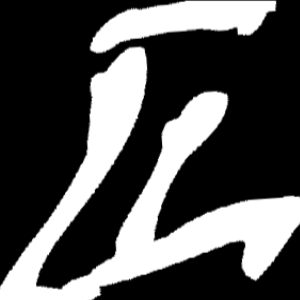

In [16]:
ex = df.sample(1).iloc[0]
print(ex)
img = load_image(ex.image, (300, 300), 1, augment=True)
Image.fromarray((np.array(img[:, :, 0]) * 255).astype(np.uint8))

In [17]:
BATCH_SIZE = 256 * NUM_GPUS # smaller batch size: more updates
IMAGE_SIZE = (224, 224)

In [18]:
class_weight = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=LBL_BIN.classes_,
    y=train_df.label
)

In [19]:
class AKUSequence(keras.utils.Sequence):
    
    def __init__(self, df, image_size=IMAGE_SIZE, channels=3, batch_size=64, mode='train'):
        self.image_size = image_size
        self.channels = channels
        
        self.batch_size = batch_size
        if mode not in ['train', 'test']:
            raise ValueError("mode must be 'train' or 'test'")
        self.mode = mode
        
        self.images = df.image
        self.labels = df.label
        
        self.indexes = range(len(self.images))
    
    def __len__(self):
        return int(np.ceil(len(self.indexes) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = range(len(self.images))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))
            
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        return LBL_BIN.transform(batch_labels)
    
    def get_batch_images(self, idx):
        batch_images = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = np.empty((len(batch_images), *self.image_size, self.channels))
        for i, img in enumerate(batch_images):
            images[i] = load_image(
                img,
                size=self.image_size, channels=self.channels,
                augment=self.mode == 'train'
            )
        
        return images
    
    def __getitem__(self, idx):
        batch_x = self.get_batch_images(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [20]:
len(LBL_BIN.classes_)

58

In [21]:
def print_report(y_true, y_pred):
    print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))

create model

In [22]:
BATCH_SIZE = 256
IMAGE_SIZE = (128, 128)
NUM_CHANNELS = 1
NUM_CLASSES = len(LBL_BIN.classes_)

s_train = AKUSequence(train_df, IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE, mode='train')
s_test = AKUSequence(test_df, IMAGE_SIZE, NUM_CHANNELS, BATCH_SIZE, mode='test')

class_weight = sklearn.utils.compute_class_weight(
    class_weight='balanced',
    classes=train_df.label.unique(),
    y=train_df.label
)

inputs = keras.layers.Input(shape=(*IMAGE_SIZE, NUM_CHANNELS))

# input conv
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D((2, 2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D((2, 2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(len(LBL_BIN.classes_), activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)


model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(),
    metrics=[keras.metrics.categorical_accuracy, keras.metrics.top_k_categorical_accuracy]
)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [23]:
experiment = 'AKU-128-C32C32PC64C64PFD512-adadelta_{}'.format(LABEL)

tb_dir = os.path.join(OUTDIR, 'tensorboard', experiment)
if os.path.isdir(tb_dir):
    shutil.rmtree(tb_dir)

os.makedirs(tb_dir, exist_ok=True)

tb = keras.callbacks.TensorBoard(
    log_dir=tb_dir, 
    batch_size=BATCH_SIZE,
    write_images=True
)

h = model.fit_generator(
    generator=s_train,
    validation_data=s_test,
    epochs=1000,
    use_multiprocessing=True,
    workers=4,
    class_weight=class_weight,
    callbacks=[tb, keras.callbacks.EarlyStopping(patience=50)]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
11/11 [==============================] - 9s 781ms/step - loss: 4.1080 - categorical_accuracy: 0.0108 - top_k_categorical_accuracy: 0.0566 - val_loss: 4.0003 - val_categorical_accuracy: 0.0299 - val_top_k_categorical_accuracy: 0.2672
Epoch 2/1000
11/11 [==============================] - 2s 178ms/step - loss: 3.9769 - categorical_accuracy: 0.1049 - top_k_categorical_accuracy: 0.2151 - val_loss: 3.9126 - val_categorical_accuracy: 0.0373 - val_top_k_categorical_accuracy: 0.2791
Epoch 3/1000
11/11 [==============================] - 2s 160ms/step - loss: 3.9054 - categorical_accuracy: 0.0955 - top_k_categorical_accuracy: 0.2648 - val_loss: 3.8750 - val_categorical_accuracy: 0.0851 - val_top_k_categorical_accuracy: 0.2925
Epoch 4/1000
11/11 [==============================] - 2s 166ms/step - loss: 3.8218 - categorical_accuracy: 0.1164 - top_k_categorical_accuracy: 0.2877 - val_loss: 3.8213 - val_categorical_accuracy: 0.1552 - val_top

11/11 [==============================] - 2s 181ms/step - loss: 1.7047 - categorical_accuracy: 0.5510 - top_k_categorical_accuracy: 0.8354 - val_loss: 1.5977 - val_categorical_accuracy: 0.5552 - val_top_k_categorical_accuracy: 0.8627
Epoch 66/1000
11/11 [==============================] - 2s 168ms/step - loss: 1.7373 - categorical_accuracy: 0.5256 - top_k_categorical_accuracy: 0.8311 - val_loss: 1.5335 - val_categorical_accuracy: 0.6194 - val_top_k_categorical_accuracy: 0.8597
Epoch 67/1000
11/11 [==============================] - 2s 180ms/step - loss: 1.6842 - categorical_accuracy: 0.5374 - top_k_categorical_accuracy: 0.8372 - val_loss: 1.4651 - val_categorical_accuracy: 0.6209 - val_top_k_categorical_accuracy: 0.8791
Epoch 68/1000
11/11 [==============================] - 2s 180ms/step - loss: 1.6971 - categorical_accuracy: 0.5596 - top_k_categorical_accuracy: 0.8347 - val_loss: 1.4695 - val_categorical_accuracy: 0.6164 - val_top_k_categorical_accuracy: 0.8791
Epoch 69/1000
Epoch 68/100

11/11 [==============================] - 2s 178ms/step - loss: 0.8640 - categorical_accuracy: 0.7496 - top_k_categorical_accuracy: 0.9539 - val_loss: 1.2137 - val_categorical_accuracy: 0.6925 - val_top_k_categorical_accuracy: 0.9000
Epoch 130/1000
11/11 [==============================] - 2s 158ms/step - loss: 0.9454 - categorical_accuracy: 0.7235 - top_k_categorical_accuracy: 0.9449 - val_loss: 1.1098 - val_categorical_accuracy: 0.7045 - val_top_k_categorical_accuracy: 0.9060
Epoch 131/1000
11/11 [==============================] - 2s 166ms/step - loss: 0.8646 - categorical_accuracy: 0.7503 - top_k_categorical_accuracy: 0.9549 - val_loss: 1.1622 - val_categorical_accuracy: 0.6985 - val_top_k_categorical_accuracy: 0.8985
Epoch 132/1000
11/11 [==============================] - 2s 176ms/step - loss: 0.8520 - categorical_accuracy: 0.7492 - top_k_categorical_accuracy: 0.9524 - val_loss: 1.1434 - val_categorical_accuracy: 0.7060 - val_top_k_categorical_accuracy: 0.9075
Epoch 133/1000
11/11 [=

11/11 [==============================] - 2s 159ms/step - loss: 0.4186 - categorical_accuracy: 0.8669 - top_k_categorical_accuracy: 0.9857 - val_loss: 1.0772 - val_categorical_accuracy: 0.7313 - val_top_k_categorical_accuracy: 0.9179
Epoch 194/1000
11/11 [==============================] - 2s 173ms/step - loss: 0.3298 - categorical_accuracy: 0.8887 - top_k_categorical_accuracy: 0.9911 - val_loss: 1.0921 - val_categorical_accuracy: 0.7403 - val_top_k_categorical_accuracy: 0.9179
Epoch 195/1000
11/11 [==============================] - 2s 157ms/step - loss: 0.4301 - categorical_accuracy: 0.8691 - top_k_categorical_accuracy: 0.9864 - val_loss: 1.0937 - val_categorical_accuracy: 0.7313 - val_top_k_categorical_accuracy: 0.9224
Epoch 196/1000
11/11 [==============================] - 2s 158ms/step - loss: 0.6129 - categorical_accuracy: 0.8508 - top_k_categorical_accuracy: 0.9782 - val_loss: 1.9510 - val_categorical_accuracy: 0.5985 - val_top_k_categorical_accuracy: 0.8687
Epoch 197/1000
11/11 [=

Epoch 226/1000
11/11 [==============================] - 2s 168ms/step - loss: 0.2508 - categorical_accuracy: 0.9213 - top_k_categorical_accuracy: 0.9957 - val_loss: 1.1399 - val_categorical_accuracy: 0.7433 - val_top_k_categorical_accuracy: 0.9179
Epoch 227/1000
11/11 [==============================] - 2s 179ms/step - loss: 0.2223 - categorical_accuracy: 0.9306 - top_k_categorical_accuracy: 0.9971 - val_loss: 1.1384 - val_categorical_accuracy: 0.7567 - val_top_k_categorical_accuracy: 0.9224
Epoch 228/1000
Epoch 227/1000
11/11 [==============================] - 2s 171ms/step - loss: 0.3079 - categorical_accuracy: 0.9055 - top_k_categorical_accuracy: 0.9921 - val_loss: 1.1667 - val_categorical_accuracy: 0.7448 - val_top_k_categorical_accuracy: 0.9164
Epoch 229/1000
11/11 [==============================] - 2s 169ms/step - loss: 0.2671 - categorical_accuracy: 0.9335 - top_k_categorical_accuracy: 0.9918 - val_loss: 1.1848 - val_categorical_accuracy: 0.7269 - val_top_k_categorical_accuracy: 

In [24]:
print("VAL_ACC:", h.history['val_categorical_accuracy'][-1])
print("VAL_TOP_5_ACC:", h.history['val_top_k_categorical_accuracy'][-1])

VAL_ACC: 0.7492537315212079
VAL_TOP_5_ACC: 0.9223880550754604


In [25]:
y_true = np.empty((len(test_df), len(LBL_BIN.classes_)))
y_pred = np.empty((len(test_df), len(LBL_BIN.classes_)))

for i in tqdm(range(len(s_test))):
    xb, yb = s_test[i]
    y_true[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE, :] = yb
    y_pred[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE, :] = model.predict_on_batch(xb)

In [26]:
print_report(LBL_BIN.inverse_transform(y_true), LBL_BIN.inverse_transform(y_pred))

Accuracy: 0.7493
              precision    recall  f1-score   support

      moe_10       0.62      0.83      0.71         6
     moe_101       1.00      0.50      0.67         6
     moe_103       0.76      0.72      0.74        18
    moe_103b       0.43      0.33      0.38         9
     moe_105       0.55      0.67      0.60         9
     moe_108       1.00      0.62      0.77         8
     moe_111       0.80      0.67      0.73         6
    moe_111b       0.33      0.14      0.20         7
     moe_115       0.80      0.71      0.75        17
     moe_117       0.71      0.83      0.77         6
    moe_118b       0.67      0.40      0.50         5
     moe_119       0.79      0.85      0.81        13
     moe_122       0.40      0.67      0.50         6
     moe_124       0.62      0.87      0.72        15
     moe_132       1.00      0.50      0.67         6
      moe_15       0.82      0.75      0.78        12
     moe_192       0.64      0.56      0.60        16
     moe_1

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
label_true = LBL_BIN.inverse_transform(y_true)
label_pred = LBL_BIN.inverse_transform(y_pred)

In [28]:
model.save(os.path.join(OUTDIR, "{}.model".format(experiment)))

In [29]:
with_preds = test_df.copy(deep=True)
with_preds['prediction'] = label_pred

In [30]:
from PIL import Image, ImageDraw, ImageFont

OUT_SIZE = (512, 512)
FONT = ImageFont.truetype('SourceCodePro-Semi_bold.ttf', size=16)

IMG_OUT = os.path.join(OUTDIR, "{}_predicted_images".format(experiment))

if os.path.isdir(IMG_OUT):
    shutil.rmtree(IMG_OUT)
os.makedirs(IMG_OUT)

In [31]:
def draw_prediction(row, img_out=None, font='SourceCodePro-Semi_bold.ttf', out_size=OUT_SIZE):
    
    font = ImageFont.truetype(font, size=16)
    
    img_path = row.image
    
    original = Image.open(img_path)
    original = original.convert('RGB')
    
    img = Image.new('RGB', OUT_SIZE)
    img.paste(original.resize(OUT_SIZE))
    
    draw = ImageDraw.Draw(img)
    color = (0, 255, 0) if row.label == row.prediction else (255, 0, 0)
    draw.text((5, 5), "TRUE: {} \nPRED: {}".format(row.label, row.prediction), font=font, fill=color)
    width = 5
    draw.rectangle(((0, 0), OUT_SIZE), outline=color, width=width)
    
    if img_out is not None:
        img.save(os.path.join(img_out, os.path.splitext(os.path.basename(img_path))[0] + ".jpg"), quality=95)
    else:
        return img

In [32]:
_ = joblib.Parallel(n_jobs=12)(joblib.delayed(draw_prediction)(row, IMG_OUT) for _, row in tqdm(with_preds.iterrows(), desc="drawing images", total=len(with_preds)))    